</div> <div class="alert alert-block alert-danger">
 <p class ="lead"> 
 <h1>Examen 3 </h1>
 <h2>Física Computacional</h2>
</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Julia_Programming_Language_Logo.svg/1200px-Julia_Programming_Language_Logo.svg.png" style="height:42px;display:inline">


> Autor: Celeste Castro Granados $\mathbb C \hat{e}l \mathbb s$

In [12]:
using Plots
using PyPlot
using LaTeXStrings
using LinearAlgebra
using DataFrames

# 1. Encuentra la solución numérica para la ecuación diferencial $\nabla^2 \phi = 0$ en dos dimensiones con condiciones a la frontera $\phi(0, y) = \phi(x, 0) = \phi(1, y) = \phi(x, 1) = 0$ y $\phi = 1$ para todos los puntos $x$, $y$ en dos círculos de radio $1/4$ con centros en $(0.4, 0.5)$ y $(0.6, 0.5)$. 
## Dibuje las líneas de campo vectorial que se generan de obtener $−\nabla \phi$.

### a) Solución numérica 

Para este problema, vamos a utilizar la discretización en 2D, por lo que, comenzaremos programando la función para construir la malla que necesitamos, en la cual $h_x=h_y=h$:

In [2]:
function Malla_cyr_2(x,y,r̃,V₀=1.0) #malla para dos circulos
    Mat = zeros(length(y),length(x)) # indices i,j
    for i in 2:length(y)-1 #el for va de 2:length(y)-1 porque no estamos tomando la frontera
        for j in 2:length(x)-1
            #fijamos los centros de ambos círculos
            if sqrt( (x[j]-0.4)^2 + (y[i]-0.5)^2 ) <= r̃ || sqrt( (x[j]-0.6)^2 + (y[i]-0.5)^2 ) <= r̃ 
                Mat[i,j] = V₀ #valor para los puntos interiores de ambos círculos
            else
                Mat[i,j] = rand() #valor para los puntos que no están dentro de los círculos
            end
        end
    end
    return Mat
end 

Malla_cyr_2 (generic function with 2 methods)

Y definimos nuestra malla (que va a tener los valores iniciales):

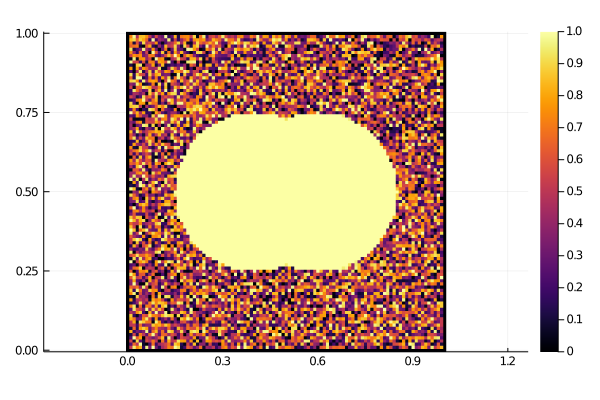

In [3]:
x = collect(0:0.01:1)
y = collect(0:0.01:1)
mi_malla = Malla_cyr_2(x,y,0.25)
heatmap(x,y,mi_malla,aspect_ratio=:equal)

Ahora, definimos la función que utilizaremos para relajar la malla, la cual utiliza el método de relajación: 

In [4]:
function relax!(Mat,V₀=1.0)
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            if Mat[i,j] ≠ V₀
                Mat[i,j] = 0.25*( Mat[i+1,j] + Mat[i-1,j] +
                    Mat[i,j+1] + Mat[i,j-1] )
            end
        end
    end
    return Mat
end

relax! (generic function with 2 methods)

Luego, probaremos la función con nuestra malla definida arriba: 

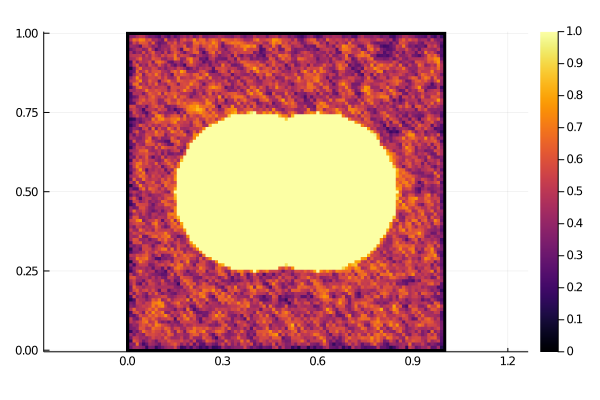

In [5]:
mi_malla = relax!(mi_malla)
heatmap(x,y,mi_malla,aspect_ratio=:equal)

Observamos que la función relax! relaja la malla una vez cada que se ejecuta, sin embargo, una vez no es suficiente para que la malla converja a la solución y tendríamos que estar ejecutando dicha función hasta que se alcance la convergencia, por lo tanto, necesitamos otra función que relaje la malla las veces necesarias, y nos entregue como resultado la malla una vez que ya haya convergido. Para esto, ocuparemos el método de Jacobi:

In [6]:
function met_jacobi_v1!(Mat,error=1e-5)
    testigo, cuenta = true,0
    while testigo == true
        Mat_old = copy(Mat)
        Mat = relax!(Mat) #va a ir relajando la malla en cada vuelta del while
        cuenta += 1
        if maximum( abs.( Mat .- Mat_old ) ) <= error #condición para que termine el proceso de relajación
            testigo = false
        end
    end
    return Mat, cuenta
end

met_jacobi_v1! (generic function with 2 methods)

Finalmente, obtenemos ahora sí la solución:

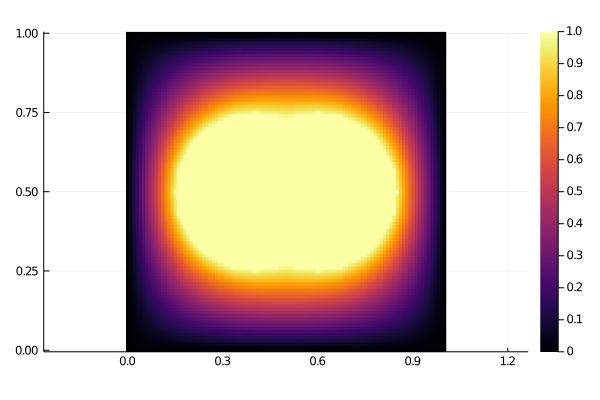

In [7]:
mi_malla = Malla_cyr_2(x,y,0.25)
mi_malla,cuenta = met_jacobi_v1!(mi_malla)
heatmap(x,y,mi_malla,aspect_ratio=:equal) #la malla ya convergió a la solución

Y para terminar, podemos graficar también las equipotenciales utilizando la función `contour`:

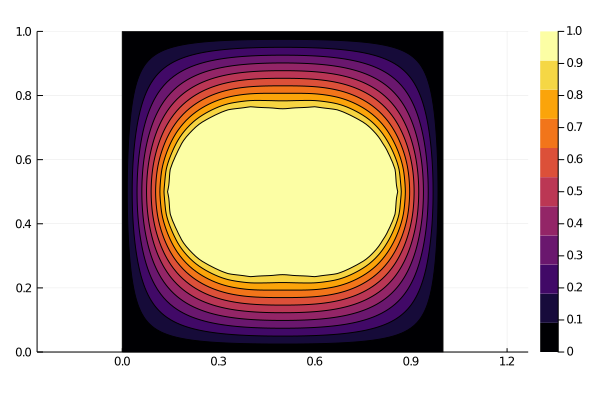

In [8]:
p1 = contour(x, y, mi_malla,nlevels=10,fill=true)
plot(p1,aspect_ratio=:equal)

### b) Líneas de campo vectorial que se generan de obtener $−\nabla \phi$.

Para este inciso, necesitamos obtener el campo eléctrico, i.e. el gradiente de la solución del inciso anterior. Por lo tanto, vamos a definir primero una función que calcule justamente el gradiente de una función:

In [9]:
#Definiremos dos funciones, una que regrese la parte x del gradiente y otra que regrese la parte y 

#Parte x
function gradiente_x(x,y,ϕ) #ϕ-función a la que se le va a calcular el gradiente
    h=x[2]-x[1]
    grad_x=zeros(length(x),length(y))
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            grad_x[i,j]=(ϕ[i,j+1]-ϕ[i,j-1])/h #calculo de la derivada
        end
    end
    return grad_x
end

#Parte y
function gradiente_y(x,y,ϕ)
    h=y[2]-y[1]
    grad_y=zeros(length(x),length(x))
    for i in 2:length(y)-1
        for j in 2:length(x)-1
            grad_y[i,j]=(ϕ[i+1,j]-ϕ[i-1,j])/h #calculo de la derivada
        end
    end
    return grad_y
end

gradiente_y (generic function with 1 method)

Y con lo anterior, ya podemos graficar el campo eléctrico, para lo cual utilizaremos la función `streamplot`:

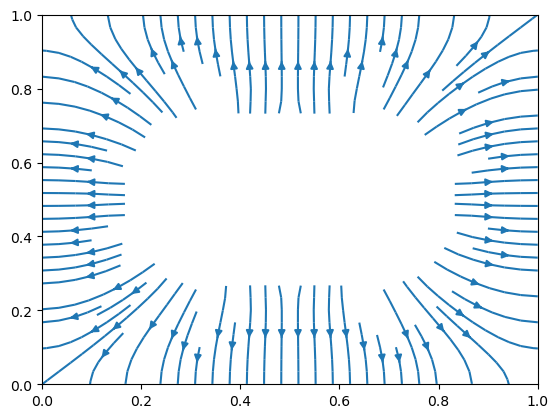

PyObject <matplotlib.streamplot.StreamplotSet object at 0x000000004FFC3FA0>

In [13]:
E_x=-1 .*gradiente_x(x,y,mi_malla)
E_y=-1 .*gradiente_y(x,y,mi_malla)
streamplot(x,y,E_x,E_y)

# 2. Encuentre la solución a la ecuación de Fourier en 2D con condición a la frontera $\phi(0, y) = \phi(x, 0) = \phi(1, y) = \phi(x, 1) = 0$ y con condición inicial $\phi(x, y, 0) = 0$ para todos los puntos afuera de los dos círculos de radio $1/4$ con centros en $(0.4, 0.5)$ y $(0.6, 0.5)$, y $\phi = 1$ para todos los puntos dentro del los dos círculos anteriores.
## Puede suponer que el coeficiente de difusión es 1.

Vamos a definir primero una función que nos permita obtener la matriz de evolución para poder obtener la solución del problema siguiendo el método de Cranck-Nicholson como lo vimos en clase:

In [14]:
function Mat_evol_CN_2D(x,y,t,D=1.0)
    Nx,Ny=length(x),length(y)
    Δx,Δy,Δt=x[2]-x[1],y[2]-y[1],t[2]-t[1]
    r = (D*Δt)/(2*Δx*Δy)
    println("r = ",r)
    A=zeros( (Nx-2)*(Ny-2) ,(Nx-2)*(Ny-2) )
    B=zeros( (Nx-2)*(Ny-2) ,(Nx-2)*(Ny-2) )
    #Para la diagonal
    for i in 1:Nx-2
       for j in 1:Ny-2
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j ]=1+4*r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j ]=1-4*r
        end
    end
    #Para las diagonales inferior y superior
    for i in 1:Nx-2
       for j in 1:Ny-3
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j+1 ]=-r
            A[ (Ny-2)*(i-1)+j+1 , (Ny-2)*(i-1)+j ]=-r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i-1)+j+1 ]=r
            B[ (Ny-2)*(i-1)+j+1 , (Ny-2)*(i-1)+j ]=r
        end
    end
    
    for i in 1:Nx-3
       for j in 1:Ny-2
            A[ (Ny-2)*(i-1)+j , (Ny-2)*(i)+j ]=-r
            A[ (Ny-2)*(i)+j , (Ny-2)*(i-1)+j ]=-r
            
            B[ (Ny-2)*(i-1)+j , (Ny-2)*(i)+j ]=r
            B[ (Ny-2)*(i)+j , (Ny-2)*(i-1)+j ]=r
        end
    end
    A_inversa=inv(A)
    Evol = A_inversa*B
    return Evol
end

Mat_evol_CN_2D (generic function with 2 methods)

Y utilizando la función anterior definimos el método de Cranck-Nicholson para 2 dimensiones:

In [15]:
function Cranck_Nicholson_2D(Ψ₀,M_evo,t)
   #Vamos a guardar las diagonales
    Nx,Ny,Nt=length(Ψ₀[:,1]),length(Ψ₀[1,:]),length(t)
    Ψ_xy_t=zeros(Nx,Ny,Nt) #Copiando Psi inicial a la solución final
    Ψ_xy_t[:,:,1] = Ψ₀
    Ψ_in_t = reshape( Ψ₀[2:end-1,2:end-1],((Nx-2)*(Ny-2),1))  #Vector
    for i in 2:Nt
       Ψ_in_t = M_evo*Ψ_in_t
        Ψ_xy_t[2:end-1,2:end-1,i]=reshape(Ψ_in_t,(Nx-2,Ny-2))
    end
    return Ψ_xy_t
end

Cranck_Nicholson_2D (generic function with 1 method)

Luego, vamos a definir otra función más, que será la que va a construir a la $\Psi_{inicial}$:

In [16]:
function Psi_ini_circ(x,y)
    Nx,Ny = length(x),length(y)
    phi=zeros(Ny,Nx)
    #cordenada y
    for i in 2:Nx-1
       for j in 2:Ny-1
            if sqrt(( x[i]-0.5 )^2+(y[j]-0.5)^2)<=(1/4)
                phi[j,i]=1
            end
        end
    end
    return phi
end

Psi_ini_circ (generic function with 1 method)

Ahora sí, ya tenemos todo lo necesario para resolver el problema. Definimos primero la $\Psi_{inicial}$ a partir de la función `Psi_ini_circ`:

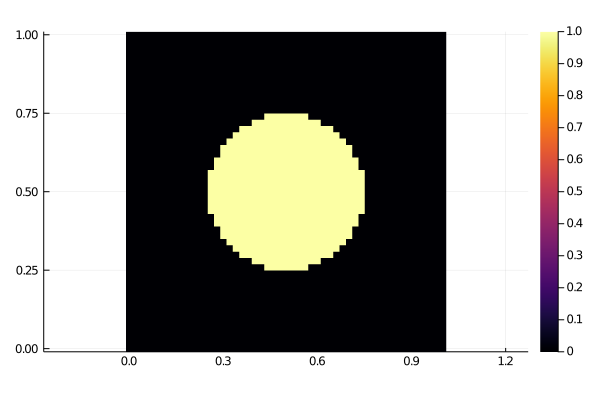

In [19]:
x=collect(0:0.02:1)
y=collect(0:0.02:1)
t=collect(0:0.0001:0.05)
psi_mat = Psi_ini_circ(x,y)
heatmap(x,y,psi_mat,aspect_ratio=:equal) #valores iniciales

Luego, definimos la matriz de evolución con la función que programamos arriba y obtenemos la solución ($\Psi_{total}$) siguiendo el método de Cranck-Nicholson:

r = 0.125


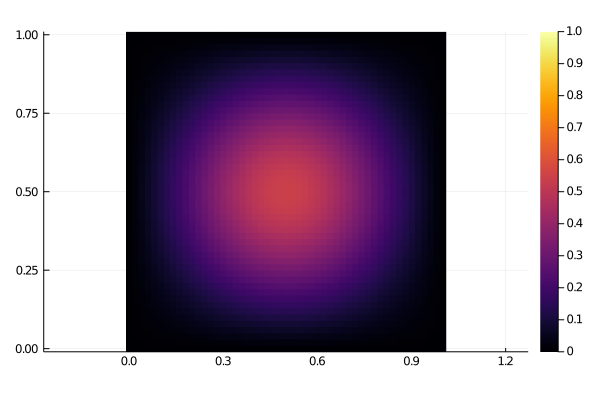

In [18]:
M_t= Mat_evol_CN_2D(x,y,t)
Psi_total = Cranck_Nicholson_2D(psi_mat,M_t,t)
heatmap(x,y,Psi_total[:,:,200],clim=(0,1),aspect_ratio=:equal) #valores finales

Y calculamos las isotermas:

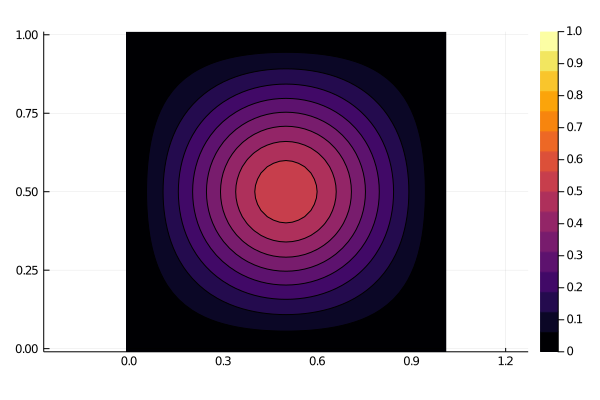

In [22]:
contourf!(x,y,Psi_total[:,:,200],clim=(0,1),aspect_ratio=:equal)

Las dos últimas gráficas representan ya la solución con los valores finales, por lo tanto, vamos a generar también una animación que muestre como va evolucionando la matriz conforme transcurre el tiempo, hasta llegar a la solución final, para poder observar todo el proceso (proceso de difusión del calor):

┌ Info: Saved animation to 
│   fn = C:\Users\celsg\Documents\Séptimo semestre\Física Computacional\2circ_calor.gif
└ @ Plots C:\Users\celsg\.julia\packages\Plots\E3MWZ\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\celsg\\Documents\\Séptimo semestre\\Física Computacional\\2circ_calor.gif")
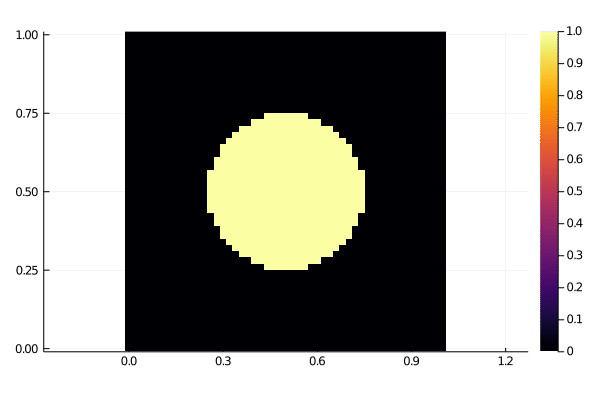

In [23]:
mi_peli=@animate for i =1:length(t)
    heatmap(x,y,Psi_total[:,:,i],clim=(0,1),aspect_ratio=:equal)
end
gif(mi_peli,"2circ_calor.gif",fps=20)

# 3. Encuentre los estados estacionarios de la ecuación de onda en 2D para una membrana rectangular $L_x = \pi$, $L_y = 2\pi$. Compare la solución numérica de los eigenvalores con la solución analítica. 
## ¿Qué sucede con la solución si ahora $L_x = \pi$, $L_y =\sqrt{2\pi}$ ? 

### a) Estados estacionarios 

Vimos en clase que podemos ver este problema como un problema de eigenvalores matricial, por lo que vamos a definir primero una función que nos construya la matriz que necesitamos:

In [24]:
function Mat_onda_2D(x,y)
    Nx,Ny = length(x),length(y)
    A = zeros(Ny*Nx,Ny*Nx)
    for i in 1:Nx
        for j in 1:Ny
            A[Ny*(i-1)+j,Ny*(i-1)+j] = -4
        end
    end
    for i in 1:Nx
        for j in 1:Ny-1
            A[Ny*(i-1)+j,Ny*(i-1)+j+1] = 1
            A[Ny*(i-1)+j+1,Ny*(i-1)+j] = 1
        end
    end
    for i in 1:Nx-1
        for j in 1:Ny
            A[Ny*(i-1)+j,Ny*i+j] = 1
            A[Ny*i+j,Ny*(i-1)+j] = 1
        end
    end
    return A
end

Mat_onda_2D (generic function with 1 method)

Ahora, con esta función definimos nuestra matriz, considerando que $L_x = \pi$ y $L_y = 2\pi$:

In [25]:
x = collect(0:0.05:π) #Lx=π, h=0.05
y = collect(0:0.05:2*π) #ly= 2π, h=0.05
M = Mat_onda_2D(x[2:end-1],y[2:end-1]); #la matriz va a estar construida solo con los puntos interiores

Y vamos a obtener los eigenvalores de la matriz M utilizando la función `eigvals`. 

In [26]:
e_vals_M = eigvals(M);

Luego, siguiendo el desarrollo del problema que hicimos en clase, observamos que los valores que corresponden a los estados estacionarios, que son los eigenvalores que estamos buscando realmente, están dados por:

$$e_{vals} = \frac{\sqrt{-\alpha}}{h} $$

En donde, $h$ es la separación en la malla (en la cual estamos suponiendo que $h_x=h_y=h$) y las $\alpha$ son los eigenvalores de la matriz M. 

In [27]:
h = x[2]-x[1] #hx=hy=h
e_vals=sqrt.(-e_vals_M)/(h);

Finalmente, vamos a comparar los valores que acabamos de obtener (eigenvalores numéricos) con los eigenvalores esperados analíticamente. Para esto, recordamos que los eigenvalores para este problema están dados por:

$$ e_{vals}= \pi \sqrt{\frac{n^2}{L_x^2} + \frac{m^2}{L_y^2}} \leftarrow \text{Valores analíticos}$$

En donde, $n$ y $m$ son números enteros.

In [30]:
Lx=π
Ly=2*π
e_vals_a=[]

#Vamos a comparar solo los primeros 25 eigenvalores
for n in 1:5
    for m in 1:5
        e_val = π * ( sqrt.( (n^2/Lx^2) + (m^2/Ly^2) ) )
        push!(e_vals_a,e_val)
    end
end

e_vals_n=sort(e_vals) #Odenamos de menor a mayor el arreglo de los eigenvalores
DataFrame(e_valores_analíticos=e_vals_a,e_valores_numéricos=e_vals_n[1:length(e_vals_a)])    

25×2 DataFrame
│ Row │ e_valores_analíticos │ e_valores_numéricos │
│     │ Any                  │ Float64             │
├─────┼──────────────────────┼─────────────────────┤
│ 1   │ 1.11803              │ 1.13112             │
│ 2   │ 1.41421              │ 1.42732             │
│ 3   │ 1.80278              │ 1.8165              │
│ 4   │ 2.23607              │ 2.08739             │
│ 5   │ 2.69258              │ 2.25077             │
│ 6   │ 2.06155              │ 2.26163             │
│ 7   │ 2.23607              │ 2.52536             │
│ 8   │ 2.5                  │ 2.70833             │
│ 9   │ 2.82843              │ 2.85372             │
│ 10  │ 3.20156              │ 3.07863             │
⋮
│ 15  │ 3.90512              │ 3.63086             │
│ 16  │ 4.03113              │ 3.64205             │
│ 17  │ 4.12311              │ 3.65723             │
│ 18  │ 4.272                │ 3.94127             │
│ 19  │ 4.47214              │ 4.05624             │
│ 20  │ 4.71699              │ 4.07783             │
│ 21  │ 5.02494              │ 4.14038             │
│ 22  │ 5.09902              │ 4.16971             │
│ 23  │ 5.22015              │ 4.27831             │
│ 24  │ 5.38516              │ 4.31844             │
│ 25  │ 5.59017              │ 4.49672             │

Por lo tanto, los eigenvalores encontrados numéricamente si coinciden con los analíticos al menos en la primera cifra (en la mayoría). Para alcanzar una mayor precisión tendríamos que disminuir el paso en los arreglos de $x$ y $y$, sin embargo, con un paso de $0.01$ se detuvo el proceso por falta de memoria, por lo que se decidió dejar el paso en $0.05$.

### b) $L_x = \pi$, $L_y =\sqrt{2\pi}$

Repetimos el procedimiento anterior, pero ahora para estos valores de $L_x$ y $L_y$:

In [31]:
x = collect(0:0.05:π)
y = collect(0:0.05:sqrt(2*π)) 
M = Mat_onda_2D(x[2:end-1],y[2:end-1])
e_vals_M = eigvals(M)
h = x[2]-x[1] #hx=hy=h
e_vals=sqrt.(-e_vals_M)/(h);

Y nuevamente comparamos con los eigenvalores esperados analíticamente:

In [32]:
Lx=π
Ly=sqrt(2*π)
e_vals_a=[]

#Vamos a comparar solo los primeros 25 eigenvalores
for n in 1:5
    for m in 1:5
        e_val = π * ( sqrt.( (n^2/Lx^2) + (m^2/Ly^2) ) )
        push!(e_vals_a,e_val)
    end
end

e_vals_n=sort(e_vals) #Odenamos de menor a mayor el arreglo de los eigenvalores
DataFrame(e_valores_analíticos=e_vals_a,e_valores_numéricos=e_vals_n[1:length(e_vals_a)]) 

25×2 DataFrame
│ Row │ e_valores_analíticos │ e_valores_numéricos │
│     │ Any                  │ Float64             │
├─────┼──────────────────────┼─────────────────────┤
│ 1   │ 1.60337              │ 1.61413             │
│ 2   │ 2.69874              │ 2.38394             │
│ 3   │ 3.89065              │ 2.70833             │
│ 4   │ 5.11202              │ 3.22688             │
│ 5   │ 6.34586              │ 3.28694             │
│ 6   │ 2.36025              │ 3.89833             │
│ 7   │ 3.20674              │ 3.94127             │
│ 8   │ 4.25878              │ 4.23729             │
│ 9   │ 5.39748              │ 4.2749              │
│ 10  │ 6.57799              │ 4.7628              │
⋮
│ 15  │ 6.94765              │ 5.52687             │
│ 16  │ 4.19175              │ 5.64327             │
│ 17  │ 4.72051              │ 5.86164             │
│ 18  │ 5.48973              │ 6.18605             │
│ 19  │ 6.41348              │ 6.30147             │
│ 20  │ 7.43437              │ 6.33889             │
│ 21  │ 5.15469              │ 6.44279             │
│ 22  │ 5.59314              │ 6.5572              │
│ 23  │ 6.25597              │ 6.57718             │
│ 24  │ 7.08045              │ 6.95558             │
│ 25  │ 8.01685              │ 7.11841             │

Para este caso, los eigenvalores numéricos también coinciden con los analíticos, aunque solo en la primer cifra (en la mayoría), i.e. con poca precisión, igual que en el inciso anterior.  